In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
from tqdm import tqdm
import pdb
from scipy.special import softmax
import torch.utils.data as tdata
import pandas as pd
import matplotlib.pyplot as plt 
import torch.backends.cudnn as cudnn
import random



def create_model(model_name):
    if model_name == 'ResNet18':
        model = torchvision.models.resnet18(pretrained=True, progress=True)
    elif model_name == 'ResNet50':
        model = torchvision.models.resnet50(pretrained=True, progress=True)
    elif model_name == 'ResNet101':
        model = torchvision.models.resnet101(pretrained=True, progress=True)
    elif model_name == 'ResNet152':
        model = torchvision.models.resnet152(pretrained=True, progress=True)
    elif model_name == 'ResNeXt101':
        model = torchvision.models.resnext101_32x8d(pretrained=True, progress=True)
    elif model_name == 'VGG16':
        model = torchvision.models.vgg16(pretrained=True, progress=True)
    elif model_name == 'ShuffleNet':
        model = torchvision.models.shufflenet_v2_x1_0(pretrained=True, progress=True)
    elif model_name == 'Inception':
        model = torchvision.models.inception_v3(pretrained=True, progress=True)
    elif model_name == 'DenseNet161':
        model = torchvision.models.densenet161(pretrained=True, progress=True)
    
    model.eval()
    model = torch.nn.DataParallel(model).cuda()
    return model

def sort_sum(scores):
    I = scores.argsort(axis=1)[:,::-1]
    ordered = np.sort(scores,axis=1)[:,::-1]
    cumsum = np.cumsum(ordered,axis=1) 
    return I, ordered, cumsum

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def validate(val_loader, model, print_bool):
    with torch.no_grad():
        batch_time = AverageMeter('batch_time')
        top1 = AverageMeter('top1')
        top5 = AverageMeter('top5')
        coverage = AverageMeter('RAPS coverage')
        size = AverageMeter('RAPS size')
        # switch to evaluate mode
        model.eval()
        end = time.time()
        N = 0
        for i, (x, target) in enumerate(val_loader):
            target = target.cuda()
            # compute output
            output, S = model(x.cuda())
            # measure accuracy and record loss
            prec1, prec5 = accuracy(output, target, topk=(1, 5))
            cvg, sz = coverage_size(S, target)

            # Update meters
            top1.update(prec1.item()/100.0, n=x.shape[0])
            top5.update(prec5.item()/100.0, n=x.shape[0])
            coverage.update(cvg, n=x.shape[0])
            size.update(sz, n=x.shape[0])

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            N = N + x.shape[0]
            if print_bool:
                print(f'\rN: {N} | Time: {batch_time.val:.3f} ({batch_time.avg:.3f}) | Cvg@1: {top1.val:.3f} ({top1.avg:.3f}) | Cvg@5: {top5.val:.3f} ({top5.avg:.3f}) | Cvg@RAPS: {coverage.val:.3f} ({coverage.avg:.3f}) | Size@RAPS: {size.val:.3f} ({size.avg:.3f})', end='')
    if print_bool:
        print('') #Endline

    return top1.avg, top5.avg, coverage.avg, size.avg 

def coverage_size(S,targets):
    covered = 0
    size = 0
    for i in range(targets.shape[0]):
        if (targets[i].item() in S[i]):
            covered += 1
        size = size + S[i].shape[0]
    return float(covered)/targets.shape[0], size/targets.shape[0]

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].float().sum()
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# Computes logits and targets from a model and loader
def get_logits_targets(model, loader):
    logits = torch.zeros((len(loader.dataset), 1000)) # 1000 classes in Imagenet.
    labels = torch.zeros((len(loader.dataset),))
    i = 0
    print(f'Computing logits for model (only happens once).')
    with torch.no_grad():
        for x, targets in tqdm(loader):
            batch_logits = model(x.cuda()).detach().cpu()
            logits[i:(i+x.shape[0]), :] = batch_logits
            labels[i:(i+x.shape[0])] = targets.cpu()
            i = i + x.shape[0]
    
    # Construct the dataset
    dataset_logits = torch.utils.data.TensorDataset(logits, labels.long()) 
    return dataset_logits


class ConformalModel(nn.Module):
    def __init__(self, model, calib_loader, alpha, kreg=None, lamda=None, randomized=True, allow_zero_sets=False, batch_size=32):
        super(ConformalModel, self).__init__()
        self.model = model 
        self.alpha = alpha
        self.T = torch.Tensor([1.3]) #initialize (1.3 is usually a good value)
        self.T, calib_logits = platt(self, calib_loader)
        self.randomized=randomized
        self.allow_zero_sets=allow_zero_sets
        self.num_classes = len(calib_loader.dataset.dataset.classes)

        #if kreg == None or lamda == None:
            #kreg, lamda, calib_logits = pick_parameters(model, calib_logits, alpha, kreg, lamda, randomized, allow_zero_sets, pct_paramtune, batch_size, lamda_criterion)

        self.penalties = np.zeros((1, self.num_classes))
        self.penalties[:, kreg:] += lamda 

        calib_loader = tdata.DataLoader(calib_logits, batch_size = batch_size, shuffle=False, pin_memory=True)

        self.Qhat = conformal_calibration_logits(self, calib_loader)

    def forward(self, *args, randomized=None, allow_zero_sets=None, **kwargs):
        if randomized == None:
            randomized = self.randomized
        if allow_zero_sets == None:
            allow_zero_sets = self.allow_zero_sets
        logits = self.model(*args, **kwargs)
        
        with torch.no_grad():
            logits_numpy = logits.detach().cpu().numpy()
            scores = softmax(logits_numpy/self.T.item(), axis=1)

            I, ordered, cumsum = sort_sum(scores)

            S = gcq(scores, self.Qhat, I=I, ordered=ordered, cumsum=cumsum, penalties=self.penalties, randomized=randomized, allow_zero_sets=allow_zero_sets)

        return logits, S


# Temperature scaling
def platt(cmodel, calib_loader, max_iters=10, lr=0.01, epsilon=0.01):
    print("Begin Platt scaling.")
    # Save logits so don't need to double compute them
    logits_dataset = get_logits_targets(cmodel.model, calib_loader)
    logits_loader = torch.utils.data.DataLoader(logits_dataset, batch_size = calib_loader.batch_size, shuffle=False, pin_memory=True)

    #T = platt_logits(cmodel, logits_loader, max_iters=max_iters, lr=lr, epsilon=epsilon)
    nll_criterion = nn.CrossEntropyLoss().cuda()

    T = nn.Parameter(torch.Tensor([1.3]).cuda())

    optimizer = optim.SGD([T], lr=lr)
    for iter in range(max_iters):
        T_old = T.item()
        for x, targets in logits_loader:
            optimizer.zero_grad()
            x = x.cuda()
            x.requires_grad = True
            out = x/T
            loss = nll_criterion(out, targets.long().cuda())
            loss.backward()
            optimizer.step()
        if abs(T_old - T.item()) < epsilon:
            break 

    print(f"Optimal T={T.item()}")
    return T, logits_dataset 


def conformal_calibration_logits(cmodel, calib_loader):
    with torch.no_grad():
        E = np.array([])
        for logits, targets in calib_loader:
            logits = logits.detach().cpu().numpy()

            scores = softmax(logits/cmodel.T.item(), axis=1)

            I, ordered, cumsum = sort_sum(scores)

            E = np.concatenate((E,giq(scores,targets,I=I,ordered=ordered,cumsum=cumsum,penalties=cmodel.penalties,randomized=True,allow_zero_sets=True)))
            
        Qhat = np.quantile(E,1-cmodel.alpha,interpolation='higher')

        return Qhat 


### CORE CONFORMAL INFERENCE FUNCTIONS

# Generalized conditional quantile function.
def gcq(scores, tau, I, ordered, cumsum, penalties, randomized, allow_zero_sets):
    penalties_cumsum = np.cumsum(penalties, axis=1)
    sizes_base = ((cumsum + penalties_cumsum) <= tau).sum(axis=1) + 1  # 1 - 1001
    sizes_base = np.minimum(sizes_base, scores.shape[1]) # 1-1000

    if randomized:
        V = np.zeros(sizes_base.shape)
        for i in range(sizes_base.shape[0]):
            V[i] = 1/ordered[i,sizes_base[i]-1] * \
                    (tau-(cumsum[i,sizes_base[i]-1]-ordered[i,sizes_base[i]-1])-penalties_cumsum[0,sizes_base[i]-1]) # -1 since sizes_base \in {1,...,1000}.

        sizes = sizes_base - (np.random.random(V.shape) >= V).astype(int)
    else:
        sizes = sizes_base

    if tau == 1.0:
        sizes[:] = cumsum.shape[1] # always predict max size if alpha==0. (Avoids numerical error.)

    if not allow_zero_sets:
        sizes[sizes == 0] = 1 # allow the user the option to never have empty sets (will lead to incorrect coverage if 1-alpha < model's top-1 accuracy

    S = list()

    # Construct S from equation (5)
    for i in range(I.shape[0]):
        S = S + [I[i,0:sizes[i]],]

    return S

# Get the 'p-value'
def get_tau(score, target, I, ordered, cumsum, penalty, randomized, allow_zero_sets): # For one example
    idx = np.where(I==target)
    tau_nonrandom = cumsum[idx]

    if not randomized:
        return tau_nonrandom + penalty[0]
    
    U = np.random.random()

    if idx == (0,0):
        if not allow_zero_sets:
            return tau_nonrandom + penalty[0]
        else:
            return U * tau_nonrandom + penalty[0] 
    else:
        return U * ordered[idx] + cumsum[(idx[0],idx[1]-1)] + (penalty[0:(idx[1][0]+1)]).sum()

# Gets the histogram of Taus. 
def giq(scores, targets, I, ordered, cumsum, penalties, randomized, allow_zero_sets):
    """
        Generalized inverse quantile conformity score function.
        E from equation (7) in Romano, Sesia, Candes.  Find the minimum tau in [0, 1] such that the correct label enters.
    """
    E = -np.ones((scores.shape[0],))
    for i in range(scores.shape[0]):
        E[i] = get_tau(scores[i:i+1,:],targets[i].item(),I[i:i+1,:],ordered[i:i+1,:],cumsum[i:i+1,:],penalties[0,:],randomized=randomized, allow_zero_sets=allow_zero_sets)

    return E



### You only need to run the following once.

In [2]:
!wget -nv -O imagenet_val.tar.gz -L https://berkeley.box.com/shared/static/pouthcomrvxw9hj64oxhacjvqdw3ihlp.gz
!mkdir imagenet_val
!tar -xf imagenet_val.tar.gz -C ./imagenet_val/ 
!mv imagenet_val/scratch/group/ilsvrc/val/* imagenet_val/
!rm -r imagenet_val/scratch

2023-03-26 06:09:24 URL:https://dl2.boxcloud.com/d/1/b1!nD8KG3mY_kaGXqtlFGAMxvWNla0nzTShnqm8RFpbJ0qQF-xE86C43LbqGPZq556EpVCBN90N118qs45OKdu9TUaiPyyscguRAimqyYhU1sa3UwvM_6H6YYrw3SBQ5kQvJYzIs9tNUK59Wk-PtePiHKSbhaa7P8jboFHmY2RqVM5hu3NytiS_DqDC4V9uUC0bREGDwHwIyzNx6TsEuiEkt7iobeSaKGyCDJxreHzUmhWl0ku7z7wSGcvCSZAxwNt8Lw8uXh9t1N8nV4og_CFdYTIN-wLK6ESUwG139pePhnyEILTqiwmF_-FVzFkHd7mrwd8JRlImGfDBCQT1KuyUw0MIEVEmMFb6gUQO9AeOCB__dBuUo_fYq9hxtms51s1pOwwL3F8Ifheg9jY5t6lQ3PN8rvLAkFwnYq-oDponjQpjJrAaxDMzdcOESJoO0-C7Q_kaUWdO-YEaFEFzkqBAiwYipLS1u0zJcpswUdjN92jxmIa3mfQkxYTejFuK7T6NhAaOPiHoJREx7zXupLBWULJjWxl865d2ZhGgjdjbFodoYNTl3Hft6mv3wHwB45qAo77Er7HoB7H98TkxyzghnblpFkEfR5BCx0wE3fh815iojhKBRoy87pwzA_oOb60ZVZOwK-WX_TNndG6RSTu8wYMu1PZCZYk3a5B92fHQbmglzTnNhIVjb9nNStv95eoUMD2RG_u_nANB_FomU31_Z9gfOEDkRQDag7_N1Zs1WXrvFnY4ta6_7Bac1mQXBPN-ePLDIoszMkqPK9L5VihrOwu3S_jxWbwk3LjeCAaj98ynbqCMB_d1XLu6gynsJX0hlJFZOEKrPMCTfDBTFSMUZR5KAaFKUrD8b707FCL6XWgQchBrak-UcJWXVD97c7o_IsjkHz615p_5i-6flUQCu6Hdb4nkma7aKSlNis0Hs1IkBXQs

In [ ]:
# Fix the random seed for reproducibility (you can change this, of course) 
seed=0
np.random.seed(seed=seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)

# Normalization from torchvision repo
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
            ])

cudnn.benchmark = True
batch_size = 128
num_calib = 10000
KREG_VAL = 5
LAMBDA_VAL = 0.01



# Get the conformal calibcration dataset
imagenet_calib_data, imagenet_val_data = torch.utils.data.random_split(torchvision.datasets.ImageFolder('./imagenet_val/', transform), [num_calib,50000-num_calib])


for modelName in ['ResNeXt101','ResNet152','ResNet101','ResNet50','ResNet18','DenseNet161','VGG16','Inception','ShuffleNet']:
  calib_loader = torch.utils.data.DataLoader(imagenet_calib_data, batch_size=batch_size, shuffle=True, pin_memory=True)
  val_loader = torch.utils.data.DataLoader(imagenet_val_data, batch_size=batch_size, shuffle=True, pin_memory=True)
  model = create_model(modelName)
  cmodel = ConformalModel(model, calib_loader, alpha=0.1, kreg=KREG_VAL, lamda=LAMBDA_VAL)
  top1, top5, coverage, size = validate(val_loader, cmodel, print_bool=True)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 79/79 [01:50<00:00,  1.40s/it]


Optimal T=1.3620930910110474


<ipython-input-1-e2ca358f9d1b>:236: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Qhat = np.quantile(E,1-cmodel.alpha,interpolation='higher')


N: 40000 | Time: 1.336 (1.321) | Cvg@1: 0.812 (0.792) | Cvg@5: 0.938 (0.945) | Cvg@RAPS: 0.922 (0.929) | Size@RAPS: 3.844 (4.251)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 79/79 [01:37<00:00,  1.24s/it]


Optimal T=1.1878708600997925
N: 40000 | Time: 0.793 (1.275) | Cvg@1: 0.859 (0.782) | Cvg@5: 0.953 (0.940) | Cvg@RAPS: 0.953 (0.928) | Size@RAPS: 2.594 (3.696)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Optimal T=1.1910858154296875
N: 40000 | Time: 0.621 (1.236) | Cvg@1: 0.719 (0.773) | Cvg@5: 0.922 (0.935) | Cvg@RAPS: 0.938 (0.929) | Size@RAPS: 5.703 (4.021)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 79/79 [01:32<00:00,  1.18s/it]


Optimal T=1.1306796073913574
N: 40000 | Time: 0.585 (1.209) | Cvg@1: 0.719 (0.761) | Cvg@5: 0.906 (0.928) | Cvg@RAPS: 0.922 (0.926) | Size@RAPS: 5.484 (4.421)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 79/79 [01:29<00:00,  1.14s/it]


Optimal T=1.085759162902832
N: 40000 | Time: 0.568 (1.178) | Cvg@1: 0.688 (0.697) | Cvg@5: 0.906 (0.891) | Cvg@RAPS: 0.906 (0.914) | Size@RAPS: 6.125 (6.163)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 79/79 [01:40<00:00,  1.27s/it]


Optimal T=1.2229689359664917
N: 40000 | Time: 1.641 (1.282) | Cvg@1: 0.797 (0.770) | Cvg@5: 0.953 (0.935) | Cvg@RAPS: 0.969 (0.927) | Size@RAPS: 3.875 (4.122)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 79/79 [01:36<00:00,  1.22s/it]


Optimal T=1.0816175937652588
N: 40000 | Time: 1.190 (1.243) | Cvg@1: 0.750 (0.716) | Cvg@5: 0.922 (0.904) | Cvg@RAPS: 0.906 (0.917) | Size@RAPS: 5.141 (5.292)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Begin Platt scaling.
Computing logits for model (only happens once).


 82%|████████▏ | 65/79 [01:17<00:16,  1.15s/it]

2023-03-26 01:59:00 URL:https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json [14193/14193] -> "human_readable_labels.json" [1]
Image 0 has label 'fountain', and the predictive set is ['fountain'].
Image 1 has label 'goose', and the predictive set is ['goose', 'black swan'].
Image 2 has label 'Airedale Terrier', and the predictive set is ['Border Terrier', 'Norfolk Terrier', 'Australian Terrier'].
Image 3 has label 'mixing bowl', and the predictive set is ['mixing bowl', 'teapot', 'soup bowl'].
Image 4 has label 'meerkat', and the predictive set is ['meerkat'].
Image 5 has label 'swimming cap', and the predictive set is ['swimming cap', 'swing', 'chain'].
Image 6 has label 'Old English Sheepdog', and the predictive set is ['Old English Sheepdog'].
Image 7 has label 'black stork', and the predictive set is ['black stork', 'oystercatcher', 'white stork'].


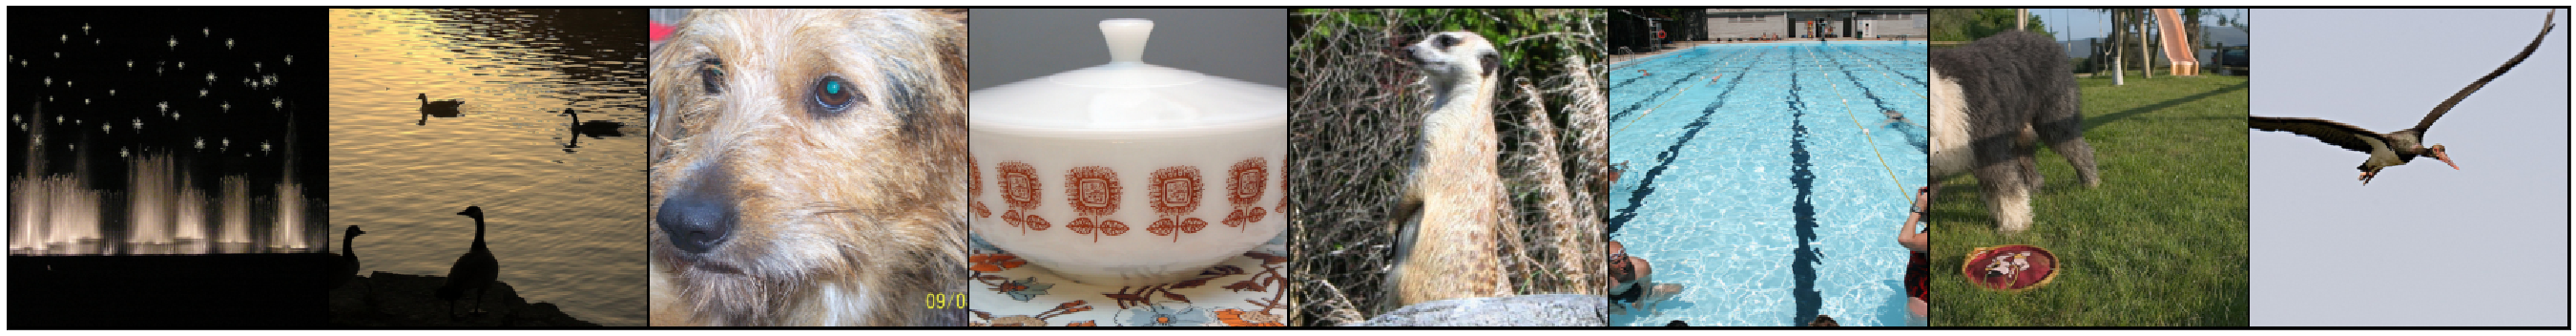

In [9]:
# Show some images the model thinks are more difficult.